Duration: 6.528 s, nsamples: 313344, samplerate: 48. kHz
Shape of the result: (128, 313344)


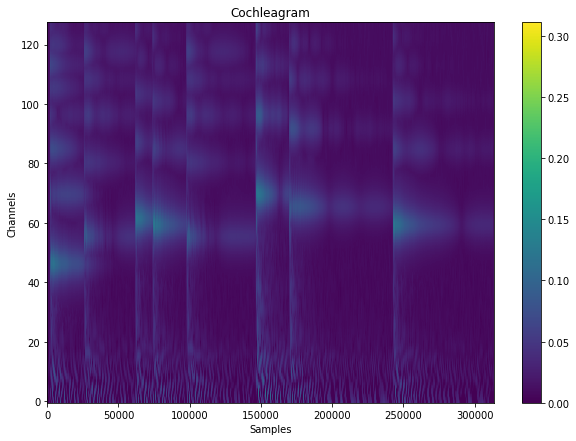

In [53]:
from os.path import join as pjoin
import numpy as np
from brian2 import *
from brian2hears import *
np.seterr(divide="ignore", invalid="ignore")

sound = Sound.load(pjoin("..", "data", "monophony", "Hedwig's Theme.wav"))
noise_rate = 0.0001
sound += noise_rate * Sound.whitenoise(sound.duration, sound.samplerate, sound.nchannels)
# sound.save(pjoin("..", "data", "monophony", "Hedwig's Theme Noised.wav"))

# Processing only left channel for now...
sound = sound.left

nchannels = 128
min_freq = 27.5*Hz  # fundamental frequency of the lowest piano key (A0, #1)
max_freq = 4.186*kHz  # fundamental frequency of the highest piano key (C8, #88)

cf = erbspace(min_freq, max_freq, nchannels)
gammatone = Gammatone(sound, cf)
cochlea = FunctionFilterbank(gammatone, lambda x: clip(x, 0, Inf)**(1.0/3.0))
output = cochlea.process().T

print(f"Duration: {sound.duration}, nsamples: {sound.nsamples}, samplerate: {sound.nsamples / sound.duration}")
print(f"Shape of the result: {output.shape}")

figure(figsize=(10, 7))
img = imshow(output, origin='lower', aspect='auto', vmin=0)
title("Cochleagram")
xlabel("Samples")
ylabel("Channels")
colorbar(img)
show()

In [54]:
import skimage
from scipy import signal

samplerate = sound.nsamples / sound.duration
window_length_s = 20 * msecond
window_length = int(window_length_s * samplerate)
window_shape = (output.shape[0], window_length)
overlap_s = 10 * msecond
overlap = int(overlap_s * samplerate)

print(f"Applying windowing to {sound.nsamples} samples:\n"""
      f"Window: {window_length_s} ({window_length} samples), shape: {window_shape}\n"
      f"Overlap: {overlap_s} ({overlap} samples)\n")

# window = signal.windows.hann(window_length)
# plot(window)
# suptitle("Hann window:")
# xlabel("Sample")
# ylabel("Amplitude")

windows = skimage.util.view_as_windows(output, window_shape, overlap).squeeze()
# windows = np.apply_along_axis(lambda vec: signal.convolve(vec, window, mode="same"), 2, windows)

print(f"Shape of the result: {windows.shape}")

Applying windowing to 313344 samples:
Window: 20. ms (960 samples), shape: (128, 960)
Overlap: 10. ms (480 samples)

Shape of the result: (651, 128, 960)


Shape of the RMS'ed windows: (128, 651)
Shape of the filtered windows: (128, 651)


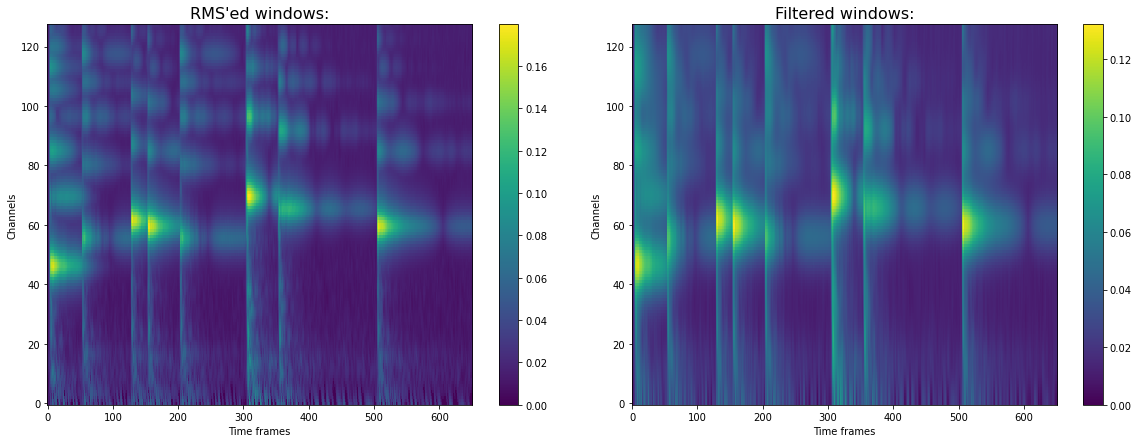

In [61]:
rmsed = np.apply_along_axis(lambda vec: np.sqrt(np.mean(np.square(vec))), 2, windows).T

print(f"Shape of the RMS'ed windows: {rmsed.shape}")
fig, (ax1, ax2) = subplots(ncols=2, figsize=(20, 7))
subplots_adjust(wspace=0.1)

img = ax1.imshow(rmsed, origin='lower', aspect='auto', vmin=0, interpolation="none")
ax1.set_title("RMS'ed windows:", fontsize=16)
ax1.set_xlabel("Time frames")
ax1.set_ylabel("Channels")
fig.colorbar(img, ax=ax1)

from scipy.ndimage import gaussian_filter
sigma = 5
filtered_gaussian = np.apply_along_axis(lambda vec: gaussian_filter(vec, sigma), 0, rmsed)

print(f"Shape of the filtered windows: {filtered_gaussian.shape}")
img = ax2.imshow(filtered_gaussian, origin='lower', aspect='auto', vmin=0, interpolation="none")
ax2.set_title("Filtered windows:", fontsize=16)
ax2.set_xlabel("Time frames")
ax2.set_ylabel("Channels")
fig.colorbar(img, ax=ax2)
show()

In [56]:
# max_amplitudes_idxs = np.argmax(filtered_gaussian, axis=0)
#
# figure(figsize=(10, 7))
# imshow(filtered_gaussian, origin='lower', aspect='auto', vmin=0, interpolation="none")
# scatter(np.arange(0, filtered_gaussian.shape[1]), max_amplitudes_idxs, s=5, c="red")
#
# suptitle("Max amplitudes across time:")
# xlabel("Time frames")
# ylabel("Channels")
# show()

# fundamental_frequencies = cf[max_amplitudes_idxs]
# max_amplitudes = filtered_gaussian[max_amplitudes_idxs, np.arange(filtered_gaussian.shape[1])]
#
# print(f"Fundamental frequencies - shape {fundamental_frequencies.shape}\n"
#       f"Max amplitudes - shape {max_amplitudes.shape}")

In [57]:
from statsmodels.tsa.stattools import acf

# Autocorrelation
autocorr = np.apply_along_axis(lambda vec: acf(vec, nlags=vec.shape[0], fft=False), 2, windows)
print(f"Autocorrelation shape: {autocorr.shape}")

# Cross-channel correlation coefficients (Pearson's)
crosscorr = np.empty((autocorr.shape[0], autocorr.shape[1]))
for t, f in np.ndindex(crosscorr.shape):
      if f + 1 < autocorr.shape[1]:
            crosscorr[t, f] = np.corrcoef(autocorr[t, f], autocorr[t, f + 1])[0, 1]
print(f"Cross-channel correlation shape: {crosscorr.shape}")

# Summary autocorrelation function
sacf = autocorr.sum(axis=1)
print(f"Summary autocorrelation shape: {sacf.shape}")

# Min and max values of lags for piano keys
min_lag = int(sound.samplerate / max_freq)
max_lag = min(int(sound.samplerate / min_freq), windows.shape[2])
print(f"Min lag: {min_lag} ({max_freq}), max_lag: {max_lag} ({min_freq})")

# Indexes of the max SACF values ~ lags corresponding to fundamental frequencies
fundamental_lags = np.argmax(sacf[:, min_lag:max_lag], axis=1) + min_lag
fundamental_frequencies = sound.samplerate / fundamental_lags
print(f"Fundamental lags shape: {fundamental_lags.shape}")
print(f"Fundamental frequencies shape: {fundamental_frequencies.shape}")

Autocorrelation shape: (651, 128, 960)
Cross-channel correlation shape: (651, 128)
Summary autocorrelation shape: (651, 960)
Min lag: 11 (4.186 kHz), max_lag: 960 (27.5 Hz)
Fundamental lags shape: (651,)
Fundamental frequencies shape: (651,)


Fundamental lag: 72, SACF: 56.68766291563378
Fundamental frequency: 0.66666667 kHz


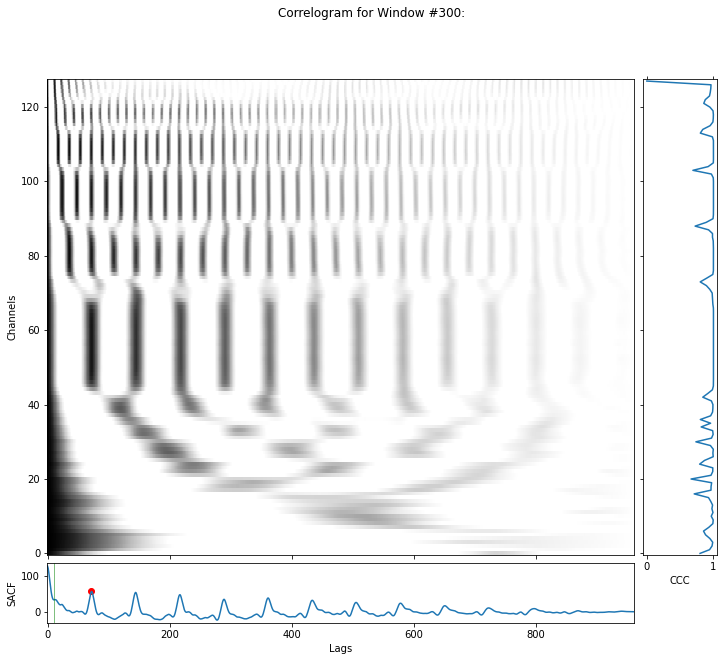

In [58]:
window_num = 300

fig, ((ax1, ax2), (ax3, ax4)) = subplots(ncols=2, nrows=2, figsize=(12, 10), sharey="row", sharex="col", gridspec_kw={"width_ratios": [8, 1],
                                                                                                                      "height_ratios": [8, 1]})
ax4.set_visible(False)
fig.suptitle(f"Correlogram for Window #{window_num}:")
subplots_adjust(wspace=0.03, hspace=0.03)

img = ax1.imshow(autocorr[window_num], origin='lower', aspect='auto', vmin=0, interpolation="none", cmap='Greys')
ax1.set_ylabel("Channels")
# fig.colorbar(img, ax=ax1)

ax2.plot(crosscorr[window_num], np.arange(autocorr.shape[1]))
ax2.set_xlabel("CCC")
ax2.tick_params(axis="x", reset=True)

fundamental_lag = fundamental_lags[window_num]
print(f"Fundamental lag: {fundamental_lag}, SACF: {sacf[window_num, fundamental_lag]}\n"
      f"Fundamental frequency: {sound.samplerate / fundamental_lag}")

ax3.plot(sacf[window_num])
ax3.scatter(fundamental_lag, sacf[window_num, fundamental_lag], color="red")
ax3.axvline(min_lag, color="green", linewidth=0.5)
ax3.set_xlabel("Lags")
ax3.set_ylabel("SACF")

show()

In [68]:
# Max values of the autocorrelation for each T-F unit
max_lags = autocorr[:, :, min_lag:max_lag].max(axis=2)
print(f"Max lags shape: {max_lags.shape}")

# Measures of how much each T-F unit is in agreement with the fundamental lag value for the current time frame
agreement_values = np.empty_like(max_lags)
for t, f in np.ndindex(agreement_values.shape):
      agreement_values[t, f] = autocorr[t, f, fundamental_lags[t]] / max_lags[t, f]
print(f"Agreement values shape: {agreement_values.shape}")

# Ideal Binary Mask estimate
threshold = 0.85
ibm = (agreement_values > threshold)
print(f"IBM shape: {ibm.shape}")

# Masked cochleagram
# masked = np.apply_along_axis(lambda vec: , 2, windows)

Max lags shape: (651, 128)
Agreement values shape: (651, 128)
IBM shape: (651, 128)


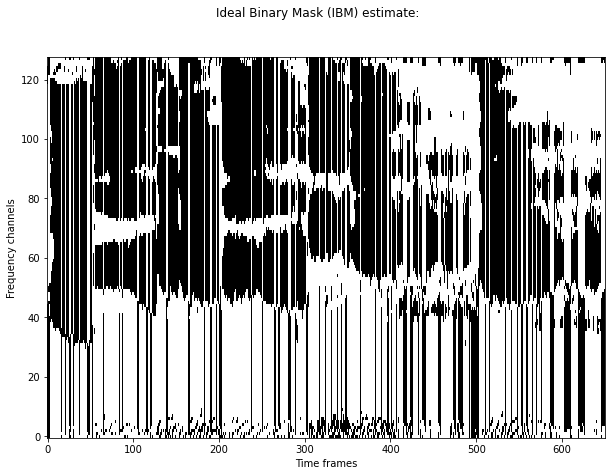

In [69]:
figure(figsize=(10, 7))
imshow(ibm.T, origin='lower', aspect='auto', vmin=0, interpolation="none", cmap="Greys")
suptitle("Ideal Binary Mask (IBM) estimate:")
xlabel("Time frames")
ylabel("Frequency channels")
show()

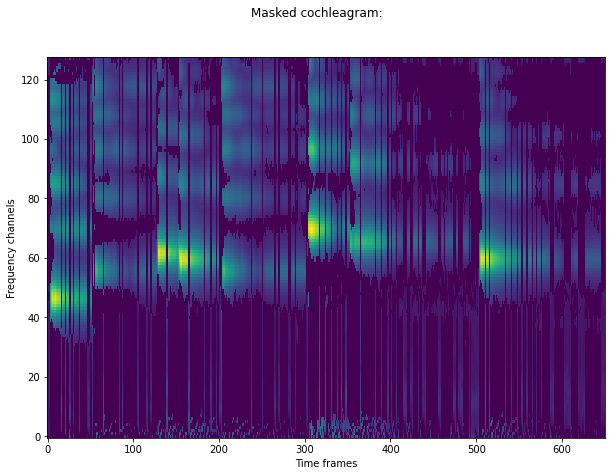

In [70]:
figure(figsize=(10, 7))
imshow(ibm.T * rmsed, origin='lower', aspect='auto', vmin=0, interpolation="none")
suptitle("Masked cochleagram:")
xlabel("Time frames")
ylabel("Frequency channels")
show()